In [1]:
%reload_ext autoreload
%autoreload 2
# data manipulation libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

## Data Context (as described in the competition)

The second step aims to provide a predictor to accurately forecast the next 100 values of a daily exchange rate. For this purpose, you still need to preprocess the data, cut the dataset and also to handle the missing values.

The training data consists of one multivariate time series with 8 features. The objective is to forecast the ‘6’th feature. The features between 0 and 6 represent different currencies of different countries' exchange rates relative to a base currency.  ‘OT’  in this context does not stand for "Oil Temperature" as in the ETTh1 dataset, it represents an additional variable or feature not directly related to the exchange rates, such as an external factor influencing exchange rates.

You can use multiple features during training if you think they are useful. The dataset contains missing values.


## Load data

In [16]:
df = pd.read_csv('data/exchange_rate_with_missing.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

## Quick overview of our exchange dataset

printing the first 3 rows

In [17]:
df.head(3)

,0,1,2,3,4,5,6,OT
date,,,,,,,,
1990-01-01,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.525486,NaN
1990-01-02,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.523972,NaN
1990-01-03,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.526316,NaN


ploting the data

In [18]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="dropdown",
        options=df.columns,
        value=['6'],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(columns):
    fig = px.line(
        df,x=df.index,y=columns,)
    fig.update_layout(title='Normalized Exchange rate dataset')
    return fig


app.run_server(debug=True)


using .info and .describe to get more details 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7488 entries, 1990-01-01 to 2010-07-02
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3331 non-null   float64
 1   1       3313 non-null   float64
 2   2       3327 non-null   float64
 3   3       3326 non-null   float64
 4   4       3466 non-null   float64
 5   5       3392 non-null   float64
 6   6       3191 non-null   float64
 7   OT      3257 non-null   float64
dtypes: float64(8)
memory usage: 526.5 KB


In [6]:
df.describe()

,0,1,2,3,4,5,6,OT
count,3331.000000,3313.000000,3327.000000,3326.000000,3466.000000,3392.000000,3191.000000,3257.000000
mean,0.781006,1.639203,0.814416,0.835148,0.141770,0.009434,0.661915,0.643647
std,0.129522,0.159019,0.115108,0.171885,0.023865,0.001552,0.082407,0.117786
min,0.484742,1.288170,0.620155,0.549739,0.109292,0.006275,0.523834,0.393153
25%,0.698400,1.541545,0.724375,0.685584,0.120809,0.008328,0.590249,0.554650
50%,0.762950,1.608105,0.798062,0.801539,0.135084,0.009215,0.641766,0.652500
75%,0.878137,1.703737,0.898096,0.988861,0.159895,0.010147,0.724533,0.716589
max,1.102536,2.109000,1.060760,1.279541,0.211242,0.013043,0.832556,0.877501


showing how many missing values that we have

In [7]:
for column in df.columns:
    missing_values_count = df[column].isnull().sum()
    print(f"Column {column} has {round(missing_values_count/df.shape[0]*100)} % missing values")

Column 0 has 56 % missing values
Column 1 has 56 % missing values
Column 2 has 56 % missing values
Column 3 has 56 % missing values
Column 4 has 54 % missing values
Column 5 has 55 % missing values
Column 6 has 57 % missing values
Column OT has 57 % missing values


In [8]:
total_missing_count = df.isnull().sum().sum()
print(f"Total missing values in the dataset: {total_missing_count}")

Total missing values in the dataset: 33301


<h1 style="color:green"> note 1:</h1> 

So far we can say that we know:

- the data has daily frequency, starting from 1990/01/10 to 2010/07/02
- the data has 7488 day in time or about 20 years of data
- the data has a lot of missing values, on average we have a 4163 missing value per column (55.6% of total data for each column)


Questions to Answer: 

- Do ween to use all other features to forecast feature number __6__? if no, which are the most promising features to use?
- How to deal with missing data? 

## Exploring the relationships between features 

Plotting each feature individually 

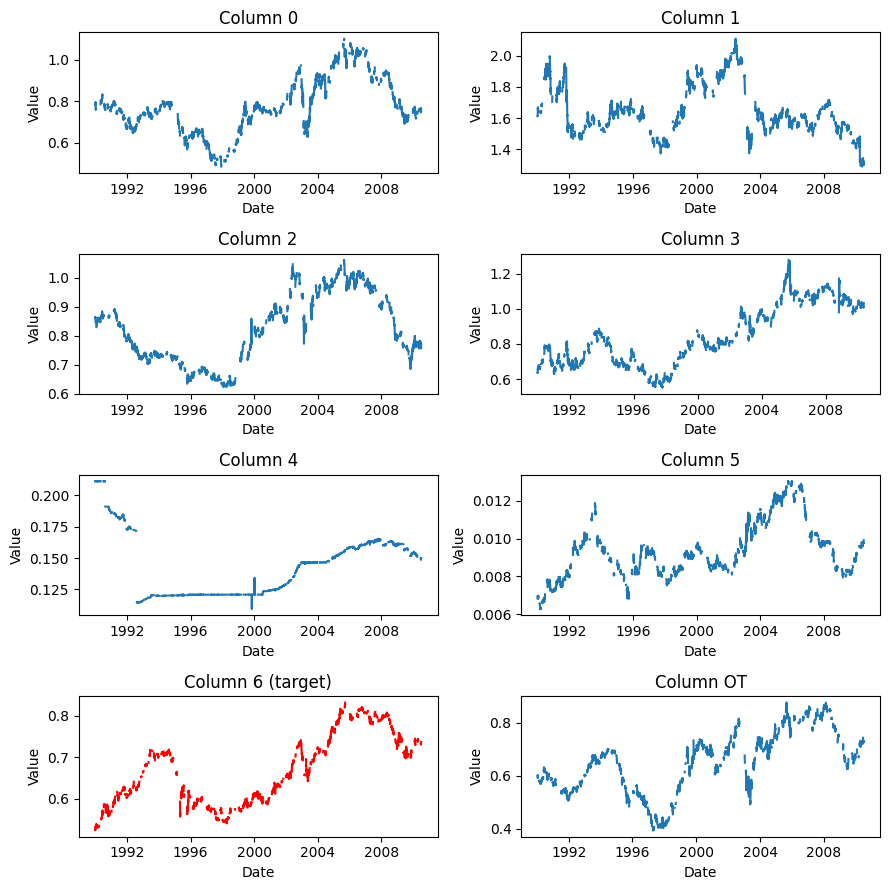

In [9]:
fig, axes = plt.subplots(nrows=len(df.columns)//2, ncols=2, figsize=(9, 9))

for i, column in enumerate(df.columns):
    if column == '6':
        axes[i//2, i%2].plot(df.index, df[column], color='red')
        axes[i//2, i%2].set_title(f'Column {column} (target)')
    else:
        axes[i//2, i%2].plot(df.index, df[column])
        axes[i//2, i%2].set_title(f'Column {column}')
    
    axes[i//2, i%2].set_xlabel('Date')
    axes[i//2, i%2].set_ylabel('Value')
    

plt.tight_layout()
plt.show()

Data distribution:

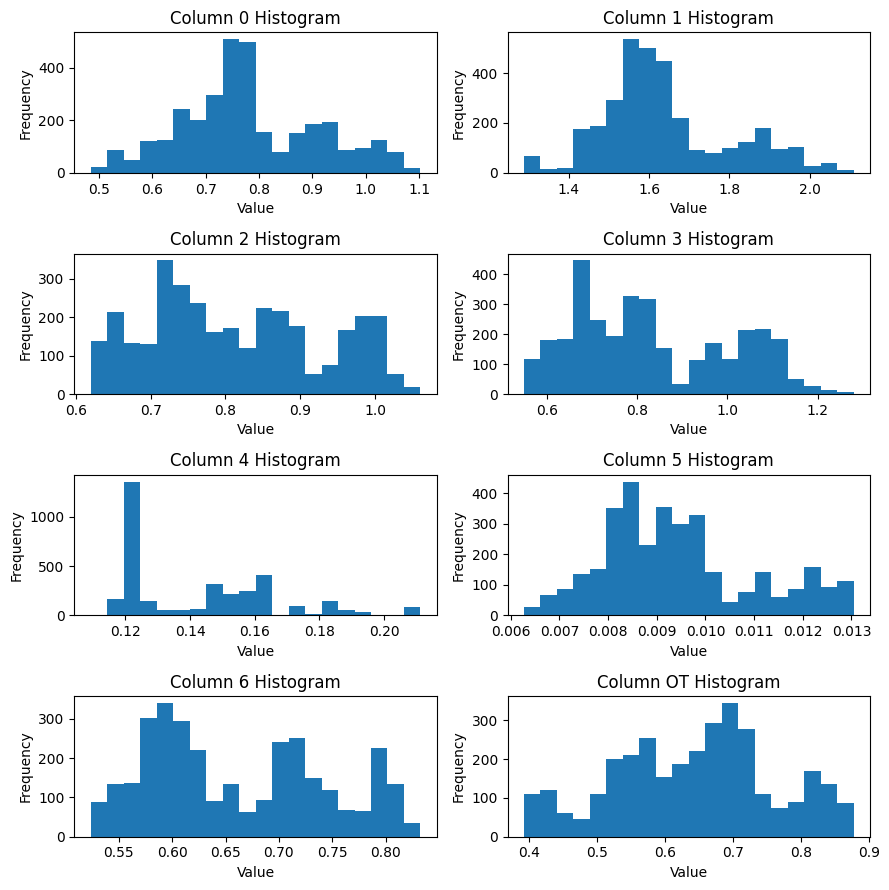

In [10]:
# histogram for each column

fig, axes = plt.subplots(nrows=len(df.columns)//2, ncols=2, figsize=(9, 9))
for i, column in enumerate(df.columns):
    axes[i//2, i%2].hist(df[column], bins=20)
    axes[i//2, i%2].set_title(f'Column {column} Histogram')
    axes[i//2, i%2].set_xlabel('Value')
    axes[i//2, i%2].set_ylabel('Frequency')
    
plt.tight_layout()
plt.show()


__normalizing data__: very important to do in our case

In [11]:
normalized_df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Correlation heatmap box

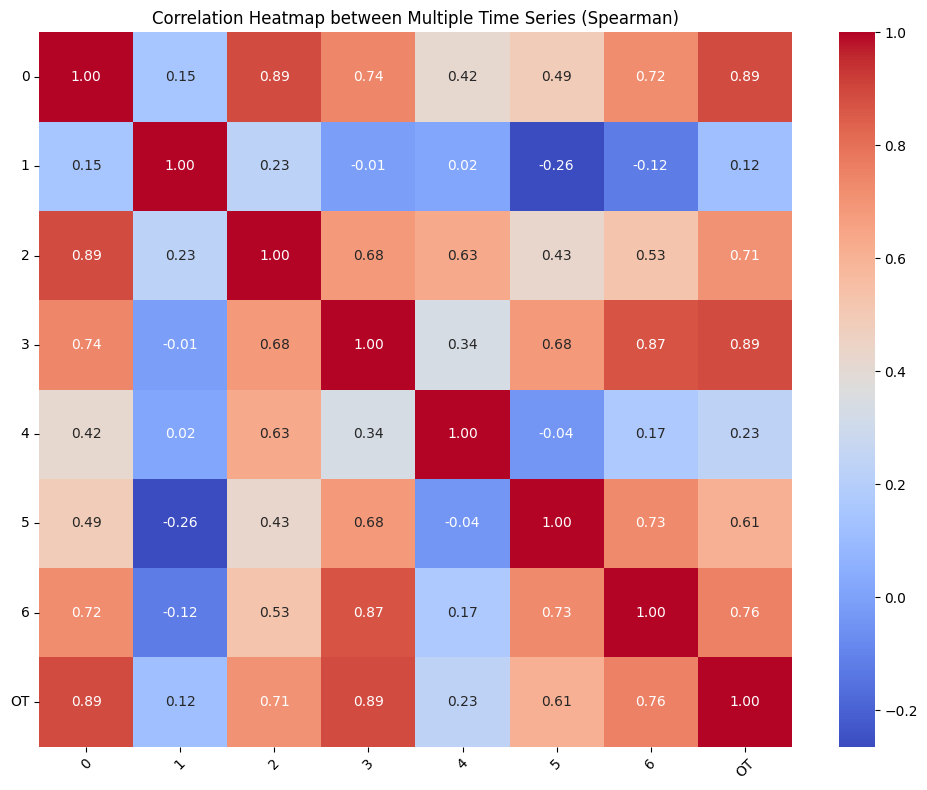

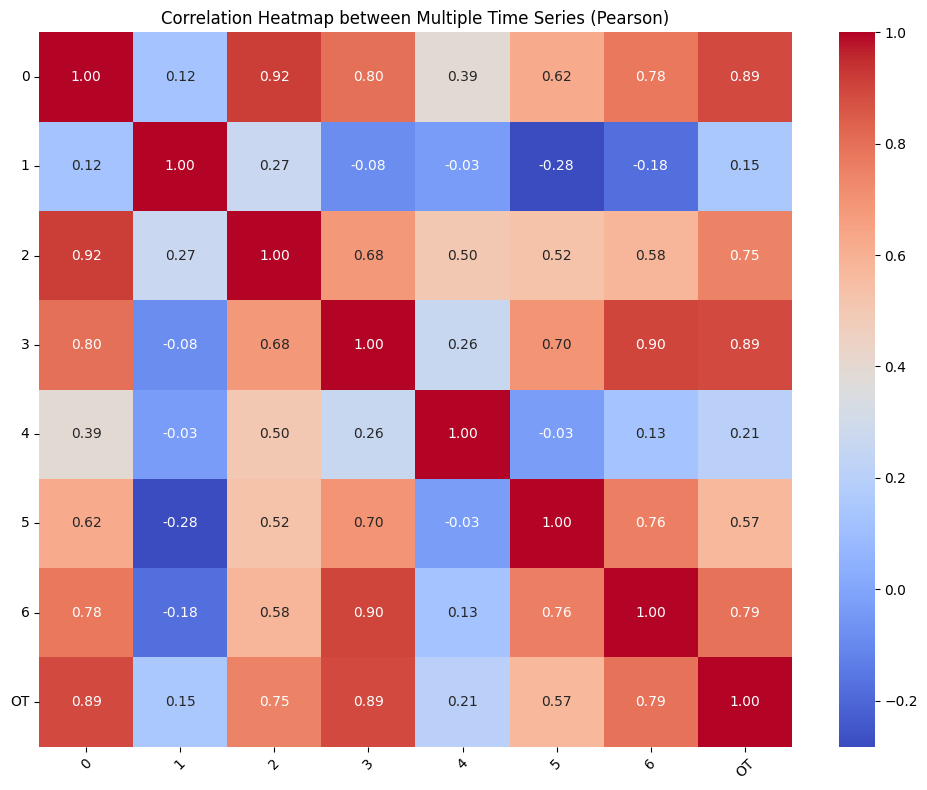

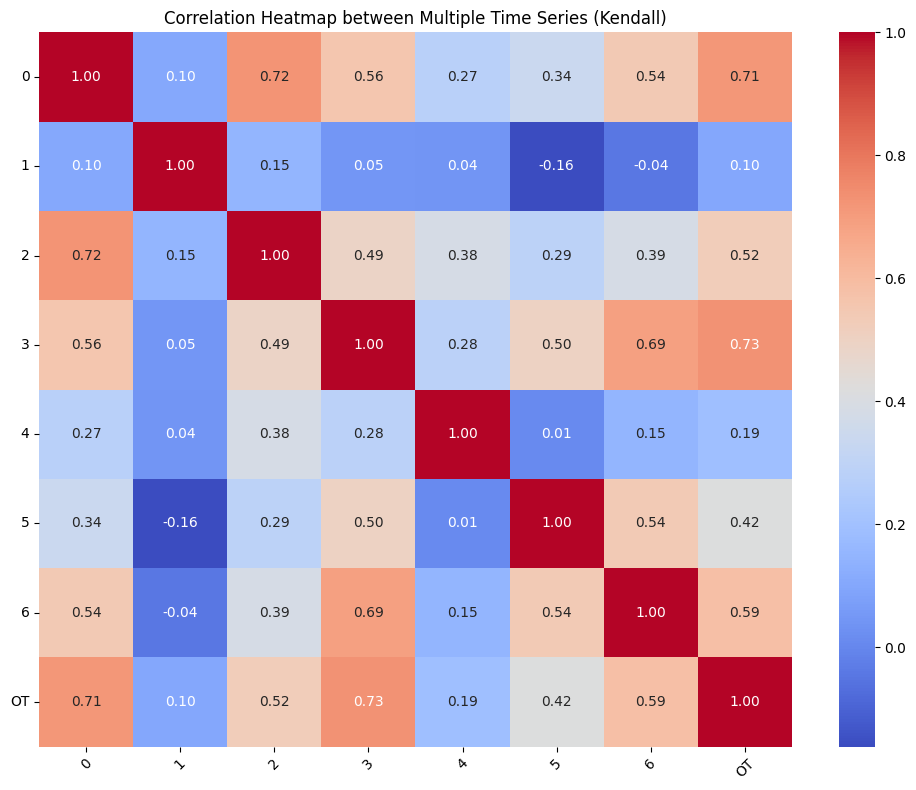

In [12]:
# Calculate the correlation matrix
corr_matrix = (normalized_df.corr(method='spearman'), normalized_df.corr(method='pearson'), normalized_df.corr(method='kendall'))
names = ['Spearman', 'Pearson', 'Kendall']

for i, corr_matrix in enumerate(corr_matrix):
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
    plt.title(f'Correlation Heatmap between Multiple Time Series ({names[i]})')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Interactive plot to view the normalized features next to each other:

In [13]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4('Analysis of Iris data using scatter matrix'),
    dcc.Dropdown(
        id="dropdown",
        options=df.columns,
        value=['6','3'],
        multi=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(columns):
    df = normalized_df
    fig = px.line(
        df,x=df.index,y=columns,)
    fig.update_layout(title='Normalized Exchange rate dataset')
    return fig


app.run_server(debug=True)

<h1 style="color:green"> note 2:</h1> 

Things that we can deduce:

- all features are highly correlated except for number __1__ and slightly correlated with number __4__
- for our target column __6__: it is highly correlated with __3__, __OT__, __0__ and __5__ (also 4 but much less)


Questions to Answer: 

- Would it be better if we include/exclude __1__ and __4__ from our analysis? (better forecast?)
- Can we leverage this high correlation to impure missing values?

## Seasonality Analysis

## Feature Engineering 